In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

from ML2_lib import loss
from ML2_lib import noise
from ML2_lib import algo_sgd
from ML2_lib import valid


In [2]:
trial_num = 100 #試行回数
result_gauss = [] #パラメータの最終結果　トライアル数*分割数k*特徴量次元
result_loss_gauss = [] # 過剰期待損失の最終結果　トライアル数*分割数k
check_k_num = 50 # 分割数　1 ~ check_k_num
rng = np.random.default_rng()
w_star = 1
X_mean = 5
X_var = 2
X_test = rng.normal(loc=X_mean,size=10000,scale=X_var)
E_test = noise.Gauss(sigma=2.2,dim=X_test.shape[0],n=1).generate()
Y_test = E_test + X_test


for _ in tqdm(range(trial_num)):


    w_per_trial = [] # モデルを貯めていく、必要かどうか
    loss_store = [] # 過剰期待損失を貯めていく
    a = 0.01 # 学習率
    c = 5 # wの初期値がとりうる範囲
    n = 500 # データセットのサンプル数
    b = 2.2 # ノイズの分散
    # 初期値wの決定
    w = rng.uniform(w_star-c,w_star+c)
    for k in range(1,check_k_num+1):
        core_store = []
        model_store = []
        valid_loss_store = []



        son = loss.LinearQuadraticLoss()
        for _ in range(k):
            # nがデータセットのサンプル数、train_numはその半分
            train_num = n // 2
            # core_num は　k分割した後のサンプル数、
            core_num = train_num  // k
            X = rng.normal(loc=X_mean,size=core_num,scale=X_var)
            Y = noise.Gauss(sigma=b,dim=X.shape[0],n=1).generate() + X
            data = [X,Y]

            core = algo_sgd.SGD(w_init=w,a=a,t_max=core_num-1,data=data)
            for _ in core:
                core.update(son)
            core_store.append(core)
            # :TODO fix axis
            model_store.append(np.mean(core.wstore))


        # ここまでで学習は終了,モデルの候補がk個ある
        # ここからモデルの選択
        valid_num = n // 2
        rng = np.random.default_rng()
        X = rng.normal(loc=X_mean,size=valid_num,scale=X_var)
        Y = noise.Gauss(sigma=b,dim=X.shape[0],n=1).generate() + X
        tmp_loss = []

        # for文を使っているので要修正
        for i in range(k):
            for j in range(k):
                core_num = valid_num // k
                try:
                    tmp_loss.append(son.f(Y[j:j+core_num],X[j:j+core_num],model_store[i]))
                except:
                    raise ValueError()
            valid_loss_store.append(valid.median_of_means(seq=np.array(tmp_loss),n_blocks=3))

        index = np.argmin(valid_loss_store)
        w_rv = model_store[index]
        w_per_trial.append(w_rv)
        loss_store.append(np.mean(son.f(y=Y_test,x=X_test,w=w_rv))- np.mean(0.5*(E_test**2)))

    result_gauss.append(np.array(w_per_trial))
    result_loss_gauss.append(np.array(loss_store))


result_gauss = np.array(result_gauss)
result_loss_gauss = np.array(result_loss_gauss)






  0%|          | 0/100 [00:00<?, ?it/s]

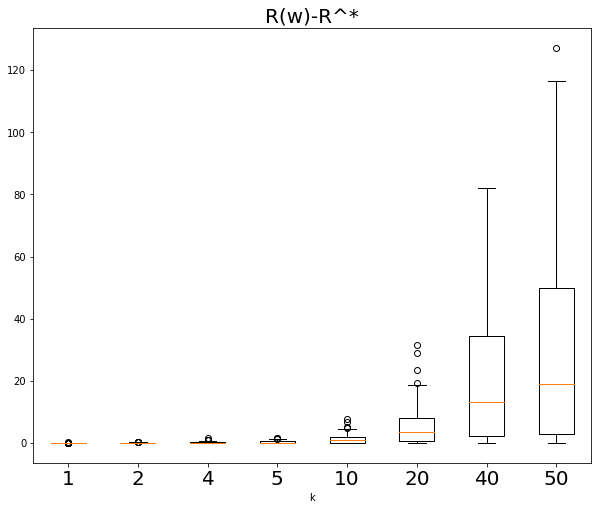

In [3]:
columns=['1', '2', '4','5','10','20','40','50']
fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_subplot(111)

bp1 = ax1.boxplot(result_loss_gauss[:,[0,1,3,4,9,19,39,49]])
ax1.set_xticklabels(columns,fontsize=20)
ax1.set_title('R(w)-R^*',fontsize=20)
ax1.set_xlabel('k')

plt.show()

In [4]:
df = pd.DataFrame(result_loss_gauss[:,[0,1,3,4,9,19,39,49]],columns=columns)

In [5]:
df.describe()

,1,2,4,5,10,20,40,50
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,0.032167,0.062927,0.214822,0.329524,1.326847,5.673897e+00,20.957736,29.271370
std,0.036965,0.071949,0.273620,0.388417,1.526048,6.321607e+00,21.845030,31.246890
min,0.000071,0.000031,-0.000001,0.000032,0.000091,-6.576482e-08,0.000067,0.000308
25%,0.008146,0.007802,0.021581,0.037291,0.088234,6.938023e-01,2.272341,2.825623
50%,0.018670,0.033854,0.106354,0.152608,0.856072,3.671319e+00,13.133094,19.025606
75%,0.038186,0.095035,0.338635,0.539512,1.950584,7.930731e+00,34.330413,50.030598
max,0.212381,0.339759,1.635884,1.659971,7.654727,3.169371e+01,82.019390,127.207758


In [6]:
# lognormal

trial_num = 100 #試行回数
result_log_normal = [] #パラメータの最終結果　トライアル数*分割数k*特徴量次元
result_loss_log_normal = [] # 過剰期待損失の最終結果　トライアル数*分割数k
check_k_num = 50 # 分割数　1 ~ check_k_num
rng = np.random.default_rng()
w_star = 1
X_mean = 5
X_var = 2
X_test = rng.normal(loc=X_mean,size=10000,scale=X_var)
E_test = noise.LogNormal(sigma=1.75,dim=X_test.shape[0],n=1).generate()
Y_test = E_test + X_test


for _ in tqdm(range(trial_num)):


    w_per_trial = [] # モデルを貯めていく、必要かどうか
    loss_store = [] # 過剰期待損失を貯めていく
    a = 0.01 # 学習率
    c = 5 # wの初期値がとりうる範囲
    n = 500 # データセットのサンプル数
    b = 1.75 # ノイズの分散
    # 初期値wの決定
    w = rng.uniform(w_star-c,w_star+c)
    for k in range(1,check_k_num+1):
        core_store = []
        model_store = []
        valid_loss_store = []



        son = loss.LinearQuadraticLoss()
        for _ in range(k):
            # nがデータセットのサンプル数、train_numはその半分
            train_num = n // 2
            # core_num は　k分割した後のサンプル数、
            core_num = train_num  // k
            X = rng.normal(loc=X_mean,size=core_num,scale=X_var)
            Y = noise.LogNormal(sigma=b,dim=X.shape[0],n=1).generate() + X
            data = [X,Y]

            core = algo_sgd.SGD(w_init=w,a=a,t_max=core_num-1,data=data)
            for _ in core:
                core.update(son)
            core_store.append(core)
            # 平均のaxis　要修正
            model_store.append(np.mean(core.wstore))


        # ここまでで学習は終了,モデルの候補がk個ある
        # ここからモデルの選択
        valid_num = n // 2
        rng = np.random.default_rng()
        X = rng.normal(loc=X_mean,size=valid_num,scale=X_var)
        Y = noise.LogNormal(sigma=b,dim=X.shape[0],n=1).generate() + X
        tmp_loss = []
        # for文を使っているので要修正
        for i in range(k):
            for j in range(k):
                core_num = valid_num // k
                tmp_loss.append(son.f(Y[j:j+core_num],X[j:j+core_num],model_store[i]))
            valid_loss_store.append(valid.median_of_means(seq=np.array(tmp_loss),n_blocks=3))

        index = np.argmin(valid_loss_store)
        w_rv = model_store[index]
        w_per_trial.append(w_rv)
        loss_store.append(np.mean(son.f(y=Y_test,x=X_test,w=w_rv))- np.mean(0.5*(E_test**2)))

    result_log_normal.append(np.array(w_per_trial))
    result_loss_log_normal.append(np.array(loss_store))


result_log_normal = np.array(result_log_normal)
result_loss_log_normal = np.array(result_loss_log_normal)



  0%|          | 0/100 [00:00<?, ?it/s]

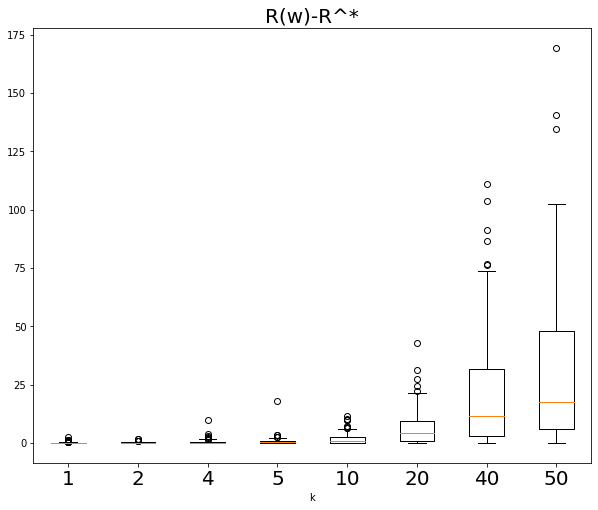

In [7]:
columns=['1', '2', '4','5','10','20','40','50']
fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_subplot(111)

bp1 = ax1.boxplot(result_loss_log_normal[:,[0,1,3,4,9,19,39,49]])
ax1.set_xticklabels(columns,fontsize=20)
ax1.set_title('R(w)-R^*',fontsize=20)
ax1.set_xlabel('k')

plt.show()

In [8]:
df = pd.DataFrame(result_loss_log_normal[:,[0,1,3,4,9,19,39,49]],columns=columns)

df.describe()

,1,2,4,5,10,20,40,50
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.163941,0.197929,0.552757,0.818466,1.881552,7.036461,22.359234,31.254685
std,0.350823,0.277805,1.140049,1.897683,2.515721,7.871338,25.928155,34.270718
min,-0.004826,-0.004804,-0.004598,-0.004744,-0.004449,-0.001085,-0.000563,-0.003889
25%,0.006540,0.032311,0.046995,0.066985,0.152168,1.033311,2.799579,5.966454
50%,0.043528,0.111888,0.188382,0.339313,0.888165,4.460096,11.758810,17.731260
75%,0.141197,0.263430,0.634991,0.987315,2.492560,9.482259,31.673146,48.122771
max,2.558522,1.589896,9.776855,17.960860,11.469796,42.891403,111.038446,169.507875
